In [275]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en", disable=['ner', 'parser'])
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
import pandas as pd
from pprint import pprint
import datetime
import pickle
import math
from sklearn.preprocessing import normalize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tuor369/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [276]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [292]:
with open('abstracts.txt', 'r') as abs:
    data = abs.read().split('\n')
# What comes out is a list of strings. One string per doc.

data_words = list(sent_to_words(data))

In [278]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words])
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# # Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_bigrams(data_words_nostops)

/home/tuor369/bin/anaconda3/envs/arxivsanity/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [279]:
# # Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 4), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 1), (40, 1), (41, 1), (42, 6), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1)]]
[[('able', 1), ('adversarial', 1), ('adversarial_exampl', 2), ('algorithm', 1), ('answer', 1), ('attack', 4), ('attain', 1), ('avoid', 1), ('benchmark', 1), ('call', 1), ('clean_example', 1), ('cleverhan', 1), ('code', 1), ('confidence', 2), ('confident', 1), ('contribute', 1), ('current', 1), ('curve', 1), ('dataset', 1)

In [280]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


In [293]:
x = lda_model.get_topics()
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
words = x.sum(axis=0)
idxs = np.argsort(words)
ids = idxs[-30:]
scores = words[ids]
#[(id2word[i], words[i]) for i in ids]


Perplexity:  -7.109779167882378


In [282]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42145186355845615


In [230]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/tuor369/bin/anaconda3/envs/arxivsanity/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.201001 -0.061294       1        1  22.440598
8      0.178248  0.069368       2        1  19.978313
6      0.181959 -0.014964       3        1  18.903027
2      0.150019  0.008872       4        1  11.354868
3      0.006616  0.144305       5        1   6.153986
9     -0.022256 -0.187618       6        1   5.089360
1     -0.191394  0.102982       7        1   4.294577
0     -0.031398  0.083168       8        1   4.043434
7     -0.134411 -0.169576       9        1   2.720836
4     -0.191854  0.013828      10        1   2.633910
5     -0.146531  0.010928      11        1   2.387098, topic_info=     Category        Freq                      Term       Total  loglift  \
42    Default  440.000000                     model  440.000000  30.0000   
191   Default  169.000000                    system  169.000000  29.0000   
208   Default  123.000000                classifier  123.000000  28.0000   
363   Default  186.000000                     image  186.000000  27.0000   
110   Default  117.000000              perturbation  117.000000  26.0000   
5     Default  507.000000                    attack  507.000000  25.0000   
36    Default  135.000000             machine_learn  135.000000  24.0000   
140   Default  110.000000                     datum  110.000000  23.0000   
405   Default  176.000000                    method  176.000000  22.0000   
60    Default   73.000000                robustness   73.000000  21.0000   
175   Default   64.000000                   problem   64.000000  20.0000   
1760  Default   28.000000                  detector   28.000000  19.0000   
2258  Default   31.000000                  backdoor   31.000000  18.0000   
1     Default  273.000000               adversarial  273.000000  17.0000   
18    Default   74.000000                   dataset   74.000000  16.0000   
186   Default   70.000000                  security   70.000000  15.0000   
380   Default   49.000000                     small   49.000000  14.0000   
304   Default   77.000000  adversarial_perturbation   77.000000  13.0000   
315   Default   98.000000                       dnn   98.000000  12.0000   
1108  Default   21.000000    universal_perturbation   21.000000  11.0000   
2     Default   90.000000        adversarial_exampl   90.000000  10.0000   
545   Default   62.000000              distribution   62.000000   9.0000   
329   Default  234.000000                   network  234.000000   8.0000   
93    Default  100.000000                   example  100.000000   7.0000   
24    Default   50.000000                     exist   50.000000   6.0000   
544   Default   64.000000                 detection   64.000000   5.0000   
344   Default   69.000000                vulnerable   69.000000   4.0000   
130   Default  109.000000                 adversary  109.000000   3.0000   
3     Default  124.000000                 algorithm  124.000000   2.0000   
249   Default  133.000000                  training  133.000000   1.0000   
...       ...         ...                       ...         ...      ...   
2563  Topic11    1.996503           generates_large    2.745885   3.4164   
2038  Topic11    1.886216            ensemble_based    2.635571   3.4006   
3378  Topic11    1.864721                mutational    2.613976   3.3973   
3375  Topic11    1.864721                      grey    2.613976   3.3973   
3377  Topic11    1.864721                  mutation    2.613976   3.3973   
3499  Topic11    1.864609                    bridge    2.614013   3.3973   
979   Topic11    1.813077        publicly_available    2.562359   3.3892   
2679  Topic11    5.069472                 criterion    7.260038   3.3759   
2231  Topic11    3.894092                 variation    5.618184   3.3685   
879   Topic11    7.256350                   program   10.930097   3.3254   
1608  Topic11    3.692466                       bug    5.373628

In [283]:
db = pickle.load(open('db.p', 'rb'))
len(db)

517

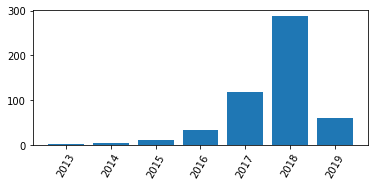

In [296]:
arxiv_texts = [v['summary'] for v in db.values()]
data_words = list(sent_to_words(arxiv_texts))
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized

dates = [datetime.datetime.strptime(v['published'], '%Y-%m-%dT%H:%M:%SZ') for v in db.values()]
datetexts = sorted(zip(arxiv_texts, dates), key=lambda x: x[1])
datetextchunks = [[k for k in datetexts if k[1].year == i] for i in range(2013, 2020)]



In [297]:
topwords = []
bigram = gensim.models.Phrases(data_words, min_count=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words])
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_bigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
coherence = []
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
x = lda_model.get_topics()
words = x.sum(axis=0)
idxs = np.argsort(words)
ids = idxs[-30:]
scores = words[ids]
topwords.append([(id2word[i], words[i]) for i in ids])

/home/tuor369/bin/anaconda3/envs/arxivsanity/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


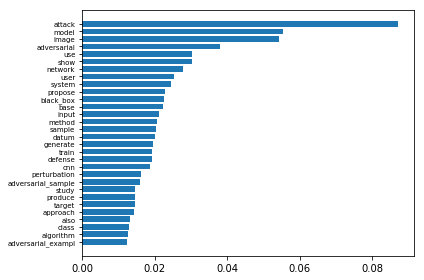

In [299]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[0]], height=3)
plt.yticks(range(0, len(topwords[0])*4, 4), labels=[tw[0] for tw in topwords[0]], fontsize=7)
# plt.yticklabels(, fontsize=12)
plt.axes().set_aspect('auto')
# plt.xlabel('Most Salient Topics in Corpus from LDA')
plt.savefig('LDA_salient.pdf')
plt.show()

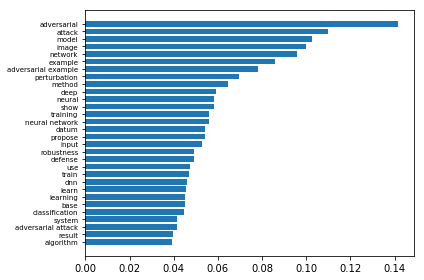

In [300]:
topwords = []
numtexts = len(arxiv_texts)
data_words = list(sent_to_words(arxiv_texts))
data_words = remove_stopwords(data_words)
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = [' '.join(t) for t in data_lemmatized]
tfidf = TfidfVectorizer(ngram_range=(1, 4), norm='l2', min_df=math.floor(numtexts*.1), max_df=math.ceil(numtexts*.9))
tfidf.fit(data_lemmatized)
id2word = {v:k for k, v in tfidf.vocabulary_.items()}
x = tfidf.transform(data_lemmatized).toarray()
words = x.mean(axis=0)
idxs = np.argsort(words)
ids = idxs[-30:]
scores = words[ids]
topwords.append([(id2word[i], words[i]) for i in ids])

plt.barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[0]], height=3)
plt.yticks(range(0, len(topwords[0])*4, 4), labels=[tw[0] for tw in topwords[0]], fontsize=7)
plt.axes().set_aspect('auto')
# plt.xlabel('Most Salient Topics in Corpus from TFIDF')
plt.savefig('tfidf_global.pdf')
plt.show()

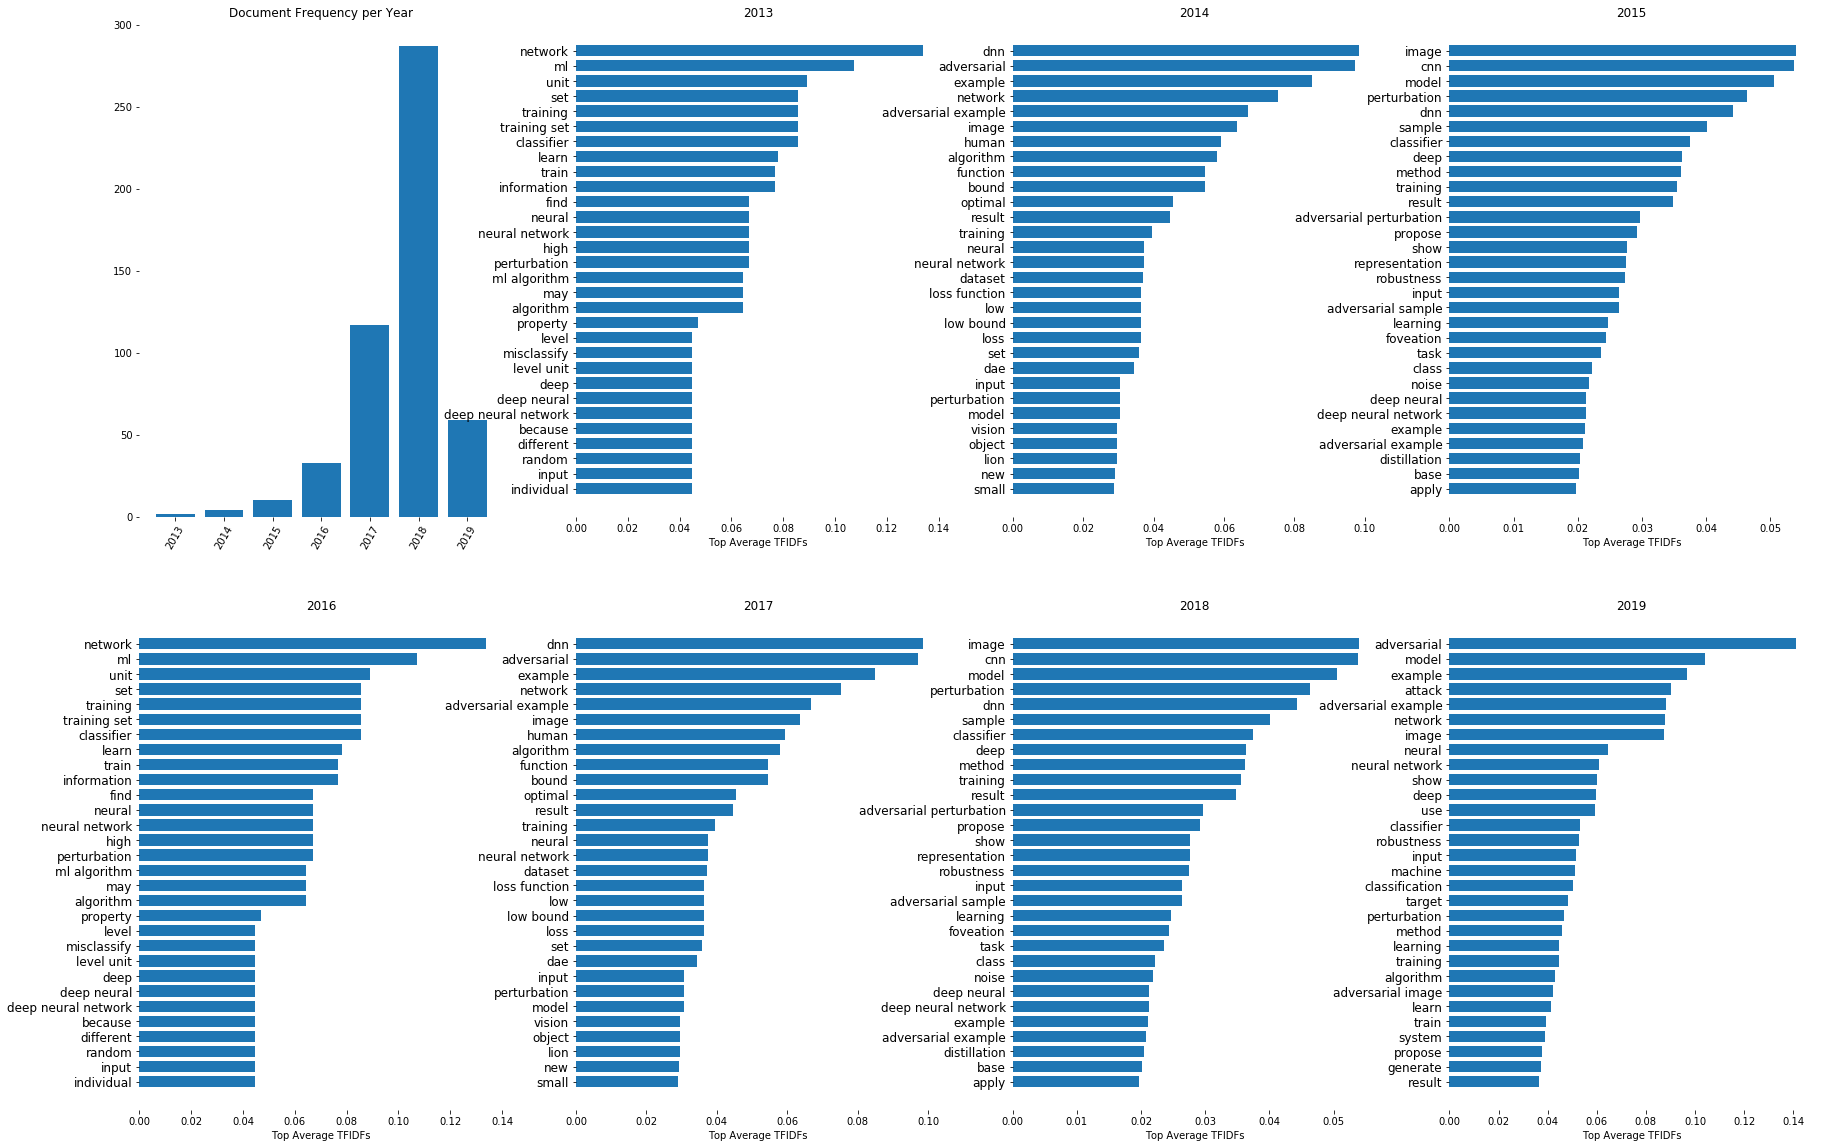

In [313]:
rcParams.update({'figure.autolayout': False})
topwords = []
for ik, dtc in enumerate(datetextchunks):
    arxiv_texts_ = [k[0] for k in dtc]
    numtexts = len(arxiv_texts_)
    data_words = list(sent_to_words(arxiv_texts_))
    data_words = remove_stopwords(data_words)
    data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    data_lemmatized = [' '.join(t) for t in data_lemmatized]
    tfidf = TfidfVectorizer(ngram_range=(1, 4), norm='l2', min_df=math.floor(numtexts*.1), max_df=math.ceil(numtexts*.9))
    tfidf.fit(data_lemmatized)
    id2word = {v:k for k, v in tfidf.vocabulary_.items()}
    x = tfidf.transform(data_lemmatized).toarray()
    words = x.mean(axis=0)
    idxs = np.argsort(words)
    ids = idxs[-30:]
    scores = words[ids]
    topwords.append([(id2word[i], words[i]) for i in ids])
f, axarr = plt.subplots(2, 4, figsize=(30,20))
freq = list([len(d) for d in datetextchunks])
freq[-1] -= 2
axarr[0][0].bar(range(2013, 2020), freq)
axarr[0][0].set_xticks(range(2013, 2020))
axarr[0][0].set_xticklabels([str(k) for k in range(2013, 2020)], rotation=60)
axarr[0][0].set_title('Document Frequency per Year')
axarr[0][0].set_aspect('auto')
axarr[0][0].spines['top'].set_visible(False)
axarr[0][0].spines['right'].set_visible(False)
axarr[0][0].spines['bottom'].set_visible(False)
axarr[0][0].spines['left'].set_visible(False)

for i in range(2013, 2016):
    axarr[0][i-2012].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2013]], height=3)
    axarr[0][i-2012].set_yticks(range(0, len(topwords[i-2013])*4, 4))
    axarr[0][i-2012].set_yticklabels([tw[0] for tw in topwords[i-2013]], fontsize=12)
    axarr[0][i-2012].set_aspect('auto')
    axarr[0][i-2012].set_title(str(i))
    axarr[0][i-2012].set_xlabel('Top Average TFIDFs')
    axarr[0][i-2012].spines['top'].set_visible(False)
    axarr[0][i-2012].spines['right'].set_visible(False)
    axarr[0][i-2012].spines['bottom'].set_visible(False)
    axarr[0][i-2012].spines['left'].set_visible(False)
    
for i in range(2016, 2020):
    axarr[1][i-2016].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2016]], height=3)
    axarr[1][i-2016].set_yticks(range(0, len(topwords[i-2016])*4, 4))
    axarr[1][i-2016].set_yticklabels([tw[0] for tw in topwords[i-2016]], fontsize=12)
    axarr[1][i-2016].set_aspect('auto')
    axarr[1][i-2016].set_title(str(i))
    axarr[1][i-2016].set_xlabel('Top Average TFIDFs')
    axarr[1][i-2016].spines['top'].set_visible(False)
    axarr[1][i-2016].spines['right'].set_visible(False)
    axarr[1][i-2016].spines['bottom'].set_visible(False)
    axarr[1][i-2016].spines['left'].set_visible(False)

plt.savefig('tfidf3.pdf')
plt.show()

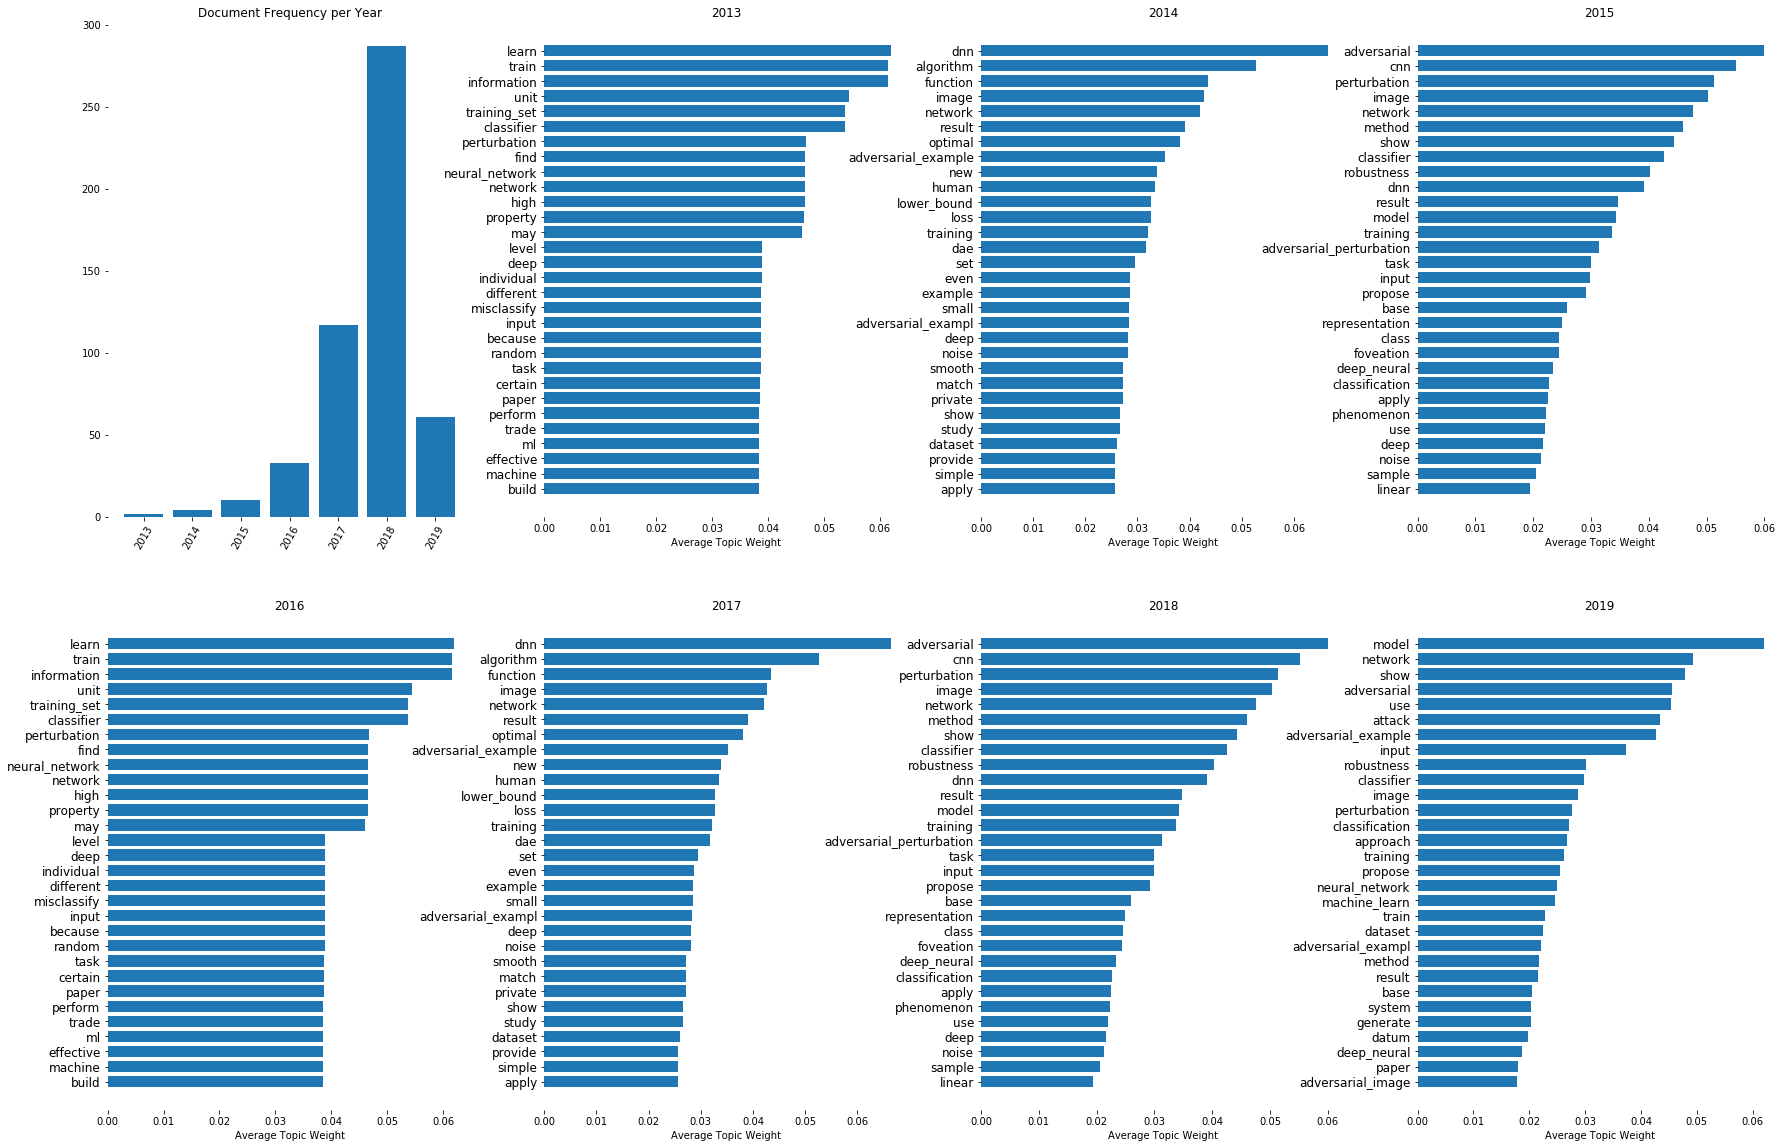

In [315]:
topwords = []
for ik, dtc in enumerate(datetextchunks):
    arxiv_texts = [k[0] for k in dtc]
    data_words = list(sent_to_words(arxiv_texts))
    bigram = gensim.models.Phrases(data_words, min_count=2) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words])
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    data_words_trigrams = make_bigrams(data_words_nostops)

    data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    coherence = []
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=5,
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    x = lda_model.get_topics()
    words = x.sum(axis=0)
    idxs = np.argsort(words)
    ids = idxs[-30:]
    scores = words[ids]
    topwords.append([(id2word[i], words[i]) for i in ids])
    
f, axarr = plt.subplots(2, 4, figsize=(30,20))
axarr[0][0].bar(range(2013, 2020), [len(d) for d in datetextchunks])
axarr[0][0].set_xticks(range(2013, 2020))
axarr[0][0].set_xticklabels([str(k) for k in range(2013, 2020)], rotation=60)
axarr[0][0].set_title('Document Frequency per Year')
axarr[0][0].set_aspect('auto')
axarr[0][0].spines['top'].set_visible(False)
axarr[0][0].spines['right'].set_visible(False)
axarr[0][0].spines['bottom'].set_visible(False)
axarr[0][0].spines['left'].set_visible(False)

for i in range(2013, 2016):
    axarr[0][i-2012].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2013]], height=3)
    axarr[0][i-2012].set_yticks(range(0, len(topwords[i-2013])*4, 4))
    axarr[0][i-2012].set_yticklabels([tw[0] for tw in topwords[i-2013]], fontsize=12)
    axarr[0][i-2012].set_aspect('auto')
    axarr[0][i-2012].set_title(str(i))
    axarr[0][i-2012].set_xlabel('Average Topic Weight')
    axarr[0][i-2012].spines['top'].set_visible(False)
    axarr[0][i-2012].spines['right'].set_visible(False)
    axarr[0][i-2012].spines['bottom'].set_visible(False)
    axarr[0][i-2012].spines['left'].set_visible(False)
    
for i in range(2016, 2020):
    axarr[1][i-2016].barh(range(0, len(topwords[0])*4, 4), [t[1] for t in topwords[i-2016]], height=3)
    axarr[1][i-2016].set_yticks(range(0, len(topwords[i-2016])*4, 4))
    axarr[1][i-2016].set_yticklabels([tw[0] for tw in topwords[i-2016]], fontsize=12)
    axarr[1][i-2016].set_aspect('auto')
    axarr[1][i-2016].set_title(str(i))
    axarr[1][i-2016].set_xlabel('Average Topic Weight')
    axarr[1][i-2016].spines['top'].set_visible(False)
    axarr[1][i-2016].spines['right'].set_visible(False)
    axarr[1][i-2016].spines['bottom'].set_visible(False)
    axarr[1][i-2016].spines['left'].set_visible(False)

plt.savefig('lda3.pdf')
plt.show()